In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Package

In [2]:
!pip install libpysal
!pip install matplotlib_scalebar
!pip install ortools
!pip install spaghetti

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 30.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.26.1 which is 

In [3]:
# Basic
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm
tqdm.pandas()
import pickle
import matplotlib.pyplot as plt

# Load the shp file
import geopandas as gpd
from shapely import wkt

# Load for convert lat/long to geometry
from geopy.geocoders import Nominatim
import urllib
from urllib import parse
from urllib.request import urlopen
from urllib.request import Request
from urllib.error import HTTPError
from bs4 import BeautifulSoup
import requests
import json
import time

# For MCLP
from collections import OrderedDict
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import ortools
from ortools.linear_solver import pywraplp
import seaborn
import shapely
from shapely.geometry import Point
import spaghetti
import sys

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [4]:
os.chdir("/content/drive/MyDrive/대학원/3학기/빅데이터/광진구/광진구 빅데이터 공모전/3. 데이터 분석/2. 데이터 분석(Python)/Data")

# Utils

In [ ]:
###개인 Client ID와 Secret 필요###
client_id = 'blgwmwwnz6'
client_secret = 'KjUEKstZx7QxdqleuAIsVLJ1fIuL0z0hPvICWeMU'

In [ ]:
def lat_lon_convert_to_geo(df, address_col, pre_co, conv_co = "EPSG:5181"):
    ###네이버지도 API를 이용한 도로명주소 -> 위경도 좌표 변환 geocoding
    lat = []
    lng = []
    count = 0
    address = list(df[address_col].values)

    for add in tqdm(address):
        enc = parse.quote(add)
        url = 'https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode?query=%s'%(enc)
        request = Request(url)
        request.add_header("X-NCP-APIGW-API-KEY-ID", client_id)
        request.add_header("X-NCP-APIGW-API-KEY", client_secret)

        try:
            response = urlopen(request)

        except Exception as e:
            print(f"Error at {count}: {e}")
            lat, lng = None, None

        else:
            rescode = response.getcode()

            if rescode == 200:
                response_body = response.read().decode('utf-8')
                data = json.loads(response_body)

                if data['addresses'] == []:
                    lat, lng = None, None
                    print(f"Error at {count}: No results")
                else:
                    lng.append(data['addresses'][0]['x'])
                    lat.append(data['addresses'][0]['y'])

            else:
                print(f"Error at {count}: HTTP {rescode}")
                lat, lng = None, None

        count += 1
        time.sleep(0.1)

    df["위도"] = lat
    df["경도"] = lng

    df["geometry"] = gpd.points_from_xy(df["경도"], df["위도"])
    df = gpd.GeoDataFrame(df, geometry="geometry", crs=pre_co) # "EPSG:4326"
    df = df.to_crs(conv_co) # "EPSG:5181"

    return df

In [ ]:
class FacilityLocationModel:
    """Solve a facility location optimization model

    Parameters
    ----------
    name : str
        Problem model name; must also be defined as a class method.
    cij : numpy.ndarray
        cost matrix from origins (index of i) to destination (index of j).
        Default is None.
    ai : numpy.ndarray
        Client weight vector. Default is None.
    s : float
        service radius. Default is None.
    p : int
        Density of facilities to site. Default is None.
    write_lp : str
        file name (and path) of the LP file to write out.
    print_sol : bool
        print select results. Default is True.

    Methods
    -------
    build_lscp : build location set covering problem
    build_pmp : build p-median problem
    build_pcp : build p-center problem
    build_mclp : build maximal covering location problem
    add_vars : add variables to a model
    add_constrs : add contraints to a model
    add_obj : add an objective function to a model
    optimize : solve a model
    record_decisions : record optimal decision variables
    non_obj_vals : record non-objective values stats (eg. percent covered)
    print_results : print selected results

    Attributes
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    n_cli : int
        total client sites
    r_cli : range
        iterable of client sites
    n_fac : int
        total candidate facility sites
    r_fac : range
        iterable of candidate facility sites
    aij : numpy.ndarray
        binary coverage matrix from cij (within s service radius)
    sij : numpy.ndarray
        demand weighted cost matrix as (ai * cij).
    fac_vars : dict
        facility decision variables
    cli_vars : dict
        client decision variables
    W : ortools.linear_solver.pywraplp.Variable
        minimized maximum variable in the p-center problem formulation
    lp_formulation : str
        linear programming formulation of the model
    solve_minutes : float
        solve time in minutes
    obj_val : int or float
        model objective value
    fac2cli : dict
        facility to client relationship lookup
    cli2fac : dict
        client to facility relationship lookup
    fac2iloc : dict
        facility to dataframe index location lookup
    n_cli_uncov : int
        count of client location outside the service radius
    cli2ncov : dict
        client to covered by count lookup
    ncov2ncli : dict
        covered by count to client count lookup
    mean_dist :
        mean distance per person to the assigned facility
    perc_served :
        percentage of weighted clients covered in `s`
    """

    def __init__(
        self, name, ai=None, cij=None, s=None, p=None, write_lp=None, print_sol=True
    ):
        # Set model information
        self.name = name
        # create a solver instance
        solver_instance = pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
        # instantiate a model
        self.model = pywraplp.Solver(self.name, solver_instance)

        # Set parameters and indices
        # facility parameter
        if p:
            self.p = p
        # client count and range
        self.cij = cij
        self.n_cli = cij.shape[0]
        self.r_cli = range(self.n_cli)
        # facility count and range
        self.n_fac = self.cij.shape[1]
        self.r_fac = range(self.n_fac)
        # demand parameter
        if ai is not None:
            self.ai = ai
            self.ai_sum = ai.sum()
            # weighted demand
            try:
                self.sij = self.ai * self.cij
            except ValueError:
                self.ai = self.ai.values.reshape(self.n_cli, 1)
                self.sij = self.ai * self.cij
        # if the model has a service radius parameter
        if s:
            self.s = s
            # binary coverage matrix from cij
            self.aij = numpy.zeros(self.cij.shape)
            self.aij[self.cij <= self.s] = 1.0

        # Set decision variables, constraints, and objective function
        try:
            getattr(self, "build_" + self.name)()
        except:
            raise AttributeError(self.name, "not a defined location model.")

        # solve
        self.optimize(write_lp=write_lp)
        # records seleted decision variables
        self.record_decisions()
        # record non-objective values stats (eg. percent covered)
        self.non_obj_vals()
        # print results
        if print_sol:
            self.print_results()

    def build_lscp(self):
        """ Integer programming formulation of the Location Set Covering Problem.
        Originally Published:
            Toregas, C. and ReVelle, Charles. 1972.
            Optimal Location Under Time or Distance Constraints.
            Papers of the Regional Science Association. 28(1):133 - 144.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=1)  # set coverage constraints
        # Objective Function
        self.add_obj()

    def build_pmp(self):
        """Integer programming formulation of the p-median Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
                -1-
            ReVelle, C.S. and Swain, R.W. 1970. Central facilities location.
            Geographical Analysis. 2(1), 30-42.
                -2-
            Toregas, C., Swain, R., ReVelle, C., Bergman, L. 1971. The Location
            of Emergency Service Facilities. Operations Research. 19 (6),
            1363-1373.
                - 3 -
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        # Objective Function
        self.add_obj()

    def build_pcp(self):
        """Integer programming formulation of the p-center Problem.
        Originally Published:
            S. L. Hakimi. 1964. Optimum Locations of Switching Centers and
            the Absolute Centers and Medians of a Graph. Operations Research.
            12 (3):450-459.
        Adapted from:
            Daskin, M. (1995). Network and discrete location: Models, algorithms,
            and applications. New York: John Wiley and Sons, Inc.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=2)  # assignment constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=4)  # opening constraints
        self.add_constrs(constr=5)  # minimized maximum constraints
        # Objective Function
        self.add_obj()

    def build_mclp(self):
        """Integer programming formulation of the Maximal Covering Location Problem.
        Originally Published:
            Church, R. L and C. ReVelle. 1974. The Maximal Covering Location
            Problem. Papers of the Regional Science Association. 32:101-18.
        """
        # Decision Variables
        self.add_vars()
        # Constraints
        self.add_constrs(constr=3)  # facility constraint
        self.add_constrs(constr=6)  # maximal coverage constraints
        # Objective Function
        self.add_obj()

    def add_vars(self):
        """Add variables to a model."""
        # facility decision variables
        self.fac_vars = {j: self.model.IntVar(0, 1, "y[%i]" % (j)) for j in self.r_fac}
        # client decision variables
        if self.name == "mclp":
            self.cli_vars = {
                (i): self.model.IntVar(0, 1, "x[%i]" % (i)) for i in self.r_cli
            }
        if self.name == "pmp" or self.name == "pcp":
            self.cli_vars = {
                (i, j): self.model.IntVar(0, 1, "x[%i,%i]" % (i, j))
                for i in self.r_cli
                for j in self.r_fac
            }
        # minimized maximum variable
        if self.name == "pcp":
            self.W = self.model.NumVar(0, self.model.infinity(), "W")

    def add_constrs(self, constr=None):
        """ Add constraints to a model.
        (1) set coverage constraints
                y1 + x2 >= 1
                x1 + x3 >= 1
                x2 >= 1
        (2) assignment constraints
                x1_1 + x1_2 + x1_3 = 1
        (3) facility constraints
                y1 + y2 + y3 = p
        (4) opening constraints
                - x1_1 + y1 >= 0
                - x2_1 + y1 >= 0
                - x3_1 + y1 >= 0
        (5) minimax constraints
                cost1_1*x1_1 + cost1_2*x1_2 + cost1_3*x1_3 - W <= 0
        (6) maximal coverage constraints
                - x1 + y1 + y3 >= 0
                - x2 + y4 >= 0
        Parameters
        ----------
        constr : int {1, 2, 3, 4, 5, 6}
            Contraint type to add to model. See above for explanation.
            Default is None.
        """
        # 1 - set covering constraints
        if constr == 1:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= 1
                )
        # 2 - assignment constraints
        elif constr == 2:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum([self.cli_vars[i, j] for j in self.r_fac]) == 1
                )
        # 3 - facility constraint
        elif constr == 3:
            self.model.Add(
                self.model.Sum([self.fac_vars[j] for j in self.r_fac]) == self.p
            )
        # 4 - opening constraints
        elif constr == 4:
            for i in self.r_cli:
                for j in self.r_fac:
                    self.model.Add(self.fac_vars[j] - self.cli_vars[i, j] >= 0)
        # 5 - minimax constraints
        elif constr == 5:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.cij[i, j] * self.cli_vars[i, j] for j in self.r_fac]
                    )
                    <= self.W
                )
        # 6 - max coverage constraints
        elif constr == 6:
            for i in self.r_cli:
                self.model.Add(
                    self.model.Sum(
                        [self.aij[i, j] * self.fac_vars[j] for j in self.r_fac]
                    )
                    >= self.cli_vars[i]
                )

    def add_obj(self):
        """Add an objective function to a model."""
        if self.name == "lscp":
            self.model.Minimize(self.model.Sum([self.fac_vars[j] for j in self.r_fac]))

        elif self.name == "pmp":
            obj = [
                self.sij[i, j] * self.cli_vars[i, j]
                for i in self.r_cli
                for j in self.r_fac
            ]
            self.model.Minimize(self.model.Sum(obj))

        elif self.name == "pcp":
            self.model.Minimize(self.W)

        elif self.name == "mclp":
            obj = [self.ai.flatten()[i] * self.cli_vars[i] for i in self.r_cli]
            self.model.Maximize(self.model.Sum(obj))

    def optimize(self, write_lp=False):
        """ Solve the model.
        Parameters
        ----------
        write_lp : bool
            write out the linear programming formulation
        """

        def _redirect_to_file(self, text):
            """ Write out the model in linear programming format.
            Parameters
            ----------
            text : str
                full lp formulation in str format
            """
            original = sys.stdout
            sys.stdout = open(self.name + ".lp", "w")
            print(text)
            sys.stdout = original

        self.model.Solve()
        # linear programming formulation
        if write_lp:
            self.lp_formulation = self.model.ExportModelAsLpFormat(True)
            self._redirect_to_file(self.lp_formulation)
        # WallTime() in milliseconds
        self.solve_minutes = self.model.WallTime() * 1.66667e-5
        self.obj_val = self.model.Objective().Value()

    def record_decisions(self):
        """Record decision variable relationship following optimization."""
        # facility-to-dataframe index location lookup
        self.fac2iloc = {v.name(): k for k, v in self.fac_vars.items()}
        # client-to-dataframe index location lookup
        self.cli2iloc = {}
        # facility-to-client lookup
        self.fac2cli = {}

        # record client/service relationships
        for j in self.r_fac:
            if self.fac_vars[j].solution_value() > 0:
                jvar = self.fac_vars[j].name()
                self.fac2cli[jvar] = []
                for i in self.r_cli:
                    ivar = None
                    if self.name == "lscp":
                        if self.aij[i, j] > 0:
                            ivar = "x[%i]" % i
                            self.fac2cli[jvar].append(ivar)
                    elif self.name == "mclp":
                        if self.cli_vars[i].solution_value() > 0:
                            if self.aij[i, j] > 0:
                                ivar = self.cli_vars[i].name()
                                self.fac2cli[jvar].append(ivar)
                    else:
                        if self.cli_vars[i, j].solution_value() > 0:
                            ivar = self.cli_vars[i, j].name()
                            ivar = ivar.split(",")[0] + "]"
                            self.fac2cli[jvar].append(ivar)
                    if ivar:
                        self.cli2iloc[ivar] = i

        # client-to-facility lookup
        self.cli2fac = {}
        for cv in list(self.cli2iloc.keys()):
            self.cli2fac[cv] = []
            for k, v in self.fac2cli.items():
                if cv in v:
                    self.cli2fac[cv].append(k)

        # count of uncovered clients
        self.n_cli_uncov = self.n_cli - len(self.cli2iloc.keys())

        # clients of clients covered by n facilities
        if self.name == "lscp" or self.name == "mclp":
            self.cli2ncov = {}
            for c, fs in self.cli2fac.items():
                self.cli2ncov[c] = len(fs)
            most_coverage = max(self.cli2ncov.values())
            self.ncov2ncli = {}
            for cov_count in range(most_coverage + 1):
                if cov_count == 0:
                    self.ncov2ncli[cov_count] = self.n_cli_uncov
                    continue
                if not cov_count in list(self.cli2ncov.keys()):
                    self.ncov2ncli[cov_count] = 0
                for c, ncov in self.cli2ncov.items():
                    if ncov >= cov_count:
                        self.ncov2ncli[cov_count] += 1

    def non_obj_vals(self):
        """Record non-objective values."""
        if self.name == "pmp":
            self.mean_dist = self.obj_val / float(self.ai_sum)

        if self.name == "mclp":
            self.perc_served = (self.obj_val / float(self.ai_sum)) * 100.0

    def print_results(self):
        """Print select results."""
        print("Solve Time:", self.solve_minutes, "minutes")

        # solve time and objective value
        if self.name == "lscp":
            u1 = "facilities needed for total coverage within a "
            u2 = "%f meter service radius" % self.s
        if self.name == "pmp":
            u1 = "total weighted distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "pcp":
            u1 = "worst case distance with "
            u2 = "%i selected facilities" % self.p
        if self.name == "mclp":
            u1 = "residents within %f meters of " % self.s
            u2 = "%i selected facilities" % self.p
        units = u1 + u2

        print("Obj. Value:", self.obj_val, units)

        if self.name == "pmp":
            print("Mean weighted distance per", "person: %f" % self.mean_dist)
        if self.name == "mclp":
            print(
                "Percent of %i" % self.ai_sum, "clients covered: %f" % self.perc_served
            )

        # coverage values
        if self.name == "lscp" or self.name == "mclp":
            for ncov, ncli in self.ncov2ncli.items():
                if ncov == 0:
                    print("--- %i clients are not covered" % ncli)
                else:
                    if ncov == 1:
                        sp = "y"
                    else:
                        sp = "ies"
                    print(
                        "--- %i clients are covered" % ncli,
                        "by %i" % ncov,
                        "facilit" + sp,
                    )
def add_results(model, cli_df, fac_df, print_solution=False):
    """Add decision variable relationships to a dataframe.
    Parameters
    ----------
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations
    print_solution : bool
        print out solution decision variables. Default is False.
    Returns
    -------
    cli_df : geopandas.GeoDataFrame
        updated client locations
    fac_df : geopandas.GeoDataFrame
        updated facility locations
    """
    col_name = model.name + "_sol"
    fillers = [[cli_df, "cli2fac"], [fac_df, "fac2cli"]]
    for df, attr in fillers:
        df[col_name] = df["dv"].map(getattr(model, attr))
        df[col_name].fillna("closed", inplace=True)
    if print_solution:
        selected = fac_df[fac_df[col_name] != "closed"]
        for idx in selected.index:
            print("")
            print(selected.loc[idx, "dv"], "serving:", selected.loc[idx, col_name])
    return cli_df, fac_df
def plotter(
    fig=None,
    base=None,
    plot_aux=None,
    buffered=None,
    model=None,
    pt1_size=None,
    pt2_size=None,
    plot_res=None,
    save_fig=False,
    title=None,
    figsize=(10, 10),
):
    """ Top-level scenario plotter for location analytics.
    Parameters
    ----------
    fig : matplotlib.figure.Figure
        complete figure to plot. Default is None.
    base : matplotlib.axes._subplots.AxesSubplot
        individual axis to plot. Default is None.
    plot_aux : dict
        model data parameters dataframes to plot keyed by
        descriptive names. Default is None.
    plot_res : dict
        model data results dataframes to plot keyed by
        descriptive names. Default is None.
    buffered : see
        buffer distance from roads segments in `plot_base`.
        Default is None.
    pt1_size : float or float
        size of points to plot. `pt1_size` should always be the
        larger between `pt2_size` and `pt1_size`. Default is None.
    pt2_size : float or float
        size of points to plot. Default is None.
    model : ortools.linear_solver.pywraplp.Solver
        proxy of <Swig Object of type 'operations_research::MPSolver *'
    title : str
        plot title. Default is None.
    figsize : tuple
        Figure size for plot. Default is (12,12).
    save_fig : bool
        Default is False.
    Returns
    -------
    add_to_legend : list
        items to add to legend
    """
    for_multiplot = True
    if not fig and not base:
        for_multiplot = False
        fig, base = plt.subplots(1, 1, figsize=figsize)

    # add title
    if not for_multiplot:
        if model:
            title += " - " + model.name
        base.set_title(title, size=20)
    else:
        base.set_title(model.name, size=20)

    # plot non-results data
    if plot_aux:
        for k, df in plot_aux.items():
            if k == "streets":
                df.plot(ax=base, lw=2, edgecolor="k", zorder=1)
            if k == "buffer":
                df.plot(ax=base, facecolor="y", lw=0.25, alpha=0.25, zorder=1)
            if k == "cli_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size / 6.0
                    pcolor = "k"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "r"
                df.plot(ax=base, markersize=psize, edgecolor="k", facecolor=pcolor)
            if k == "fac_tru":
                if plot_res:
                    df = df[df[model.name + "_sol"] == "closed"]
                    psize = pt2_size
                    pcolor = "k"
                    pmarker = "*"
                else:
                    n_cli = df.shape[0]
                    psize = pt1_size
                    pcolor = "b"
                    pmarker = "o"
                df.plot(
                    ax=base,
                    markersize=psize,
                    edgecolor="k",
                    facecolor=pcolor,
                    marker=pmarker,
                )
                n_fac = df.shape[0]
            if k == "cli_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="r",
                    alpha=0.75,
                )
            if k == "fac_snp":
                df.plot(
                    ax=base,
                    markersize=pt2_size,
                    edgecolor="k",
                    facecolor="b",
                    alpha=0.75,
                )
        add_to_legend = list(plot_aux.keys())
    else:
        add_to_legend = None

    # plot results data
    if plot_res:
        dv_colors = dv_colorset(plot_res["fac_var"].dv)
        # facilities
        df = plot_res["fac_var"][plot_res["fac_var"][model.name + "_sol"] != "closed"]
        alpha = 1.0 / float(len(df.dv) - 2)
        if alpha > 0.5:
            alpha = 0.5
        # decision variable info for legend
        dvs_to_leg = {}
        # plot facilities
        for dv in df.dv:
            fac = df[df.dv == dv]
            fac.plot(
                ax=base,
                marker="*",
                markersize=pt1_size * 3.0,
                alpha=0.8,
                zorder=3,
                edgecolor="k",
                facecolor=dv_colors[dv],
            )
            # update decision variable info with set color
            dvs_to_leg[dv] = {"facecolor": dv_colors[dv]}
        # plot clients & service areas
        for f, c in model.fac2cli.items():
            fc = plot_res["cli_var"][plot_res["cli_var"].dv.isin(c)]
            fc.plot(
                ax=base,
                markersize=50,
                edgecolor="k",
                facecolor=dv_colors[f],
                alpha=alpha,
                zorder=2,
            )
            # update decision variable info with set client counts
            dvs_to_leg[f].update({"clients": fc.shape[0]})
            # create service area polygon
            service_area = concave_hull(df, fc, f)
            service_area.plot(
                ax=base, edgecolor="k", alpha=0.2, facecolor=dv_colors[f], zorder=1
            )
    else:
        dvs_to_leg = None

    if not model:

        class _ShellModel:
            """Object to mimic `model` when not present."""

            def __init__(self, plot_aux):
                try:
                    self.n_cli = plot_aux["cli_tru"].shape[0]
                    try:
                        self.n_fac = plot_aux["fac_tru"].shape[0]
                    except KeyError:
                        pass
                except KeyError:
                    pass

        try:
            model = _ShellModel(plot_aux)
        except (TypeError, KeyError):
            model = None

    if not for_multiplot:
        # create legend patches
        patches = create_patches(
            model=model,
            for_multiplot=for_multiplot,
            pt1_size=pt1_size,
            pt2_size=pt2_size,
            buffered=buffered,
            legend_aux=add_to_legend,
            dvs_to_leg=dvs_to_leg,
        )
        add_legend(patches, for_multiplot=for_multiplot)
    add_north_arrow(base)
    add_scale(base)

    if save_fig:
        plt.savefig(model.name + ".png")

    # if for a multiplot explicityly return items to add to legend
    if for_multiplot:
        return add_to_legend
def multi_plotter(
    models,
    plot_aux=None,
    plot_res=None,
    select=None,
    title=None,
    figsize=(14, 14),
    shape=(2, 2),
):
    """plot multiple base axes as one figure
    Parameters
    ----------
    models : list
        solved model objects
    select : dict
        facility-to-selection count lookup.
    shape : tuple
        dimension for subplot array. Default is (2,2).s
    plot_aux : see plotter()
    plot_res : see plotter()
    title : see plotter()
    figsize : see plotter()
    """
    pt1_size, pt2_size = 300, 60
    # convert list of models to array
    mdls = numpy.array(models).reshape(shape)
    fig, axarr = plt.subplots(
        mdls.shape[0], mdls.shape[1], figsize=figsize, sharex="col", sharey="row"
    )
    # add super title to subplot array
    plt.suptitle(title, fontsize=30)
    fig.subplots_adjust(hspace=0.1, wspace=0.005, top=0.925)
    # create each subplot
    for i in range(mdls.shape[0]):
        for j in range(mdls.shape[1]):
            add_to_legend = plotter(
                base=axarr[i, j],
                plot_aux=plot_aux,
                plot_res=plot_res,
                model=mdls[i, j],
                pt1_size=pt1_size,
                pt2_size=pt2_size,
            )
            axarr[i, j].set_aspect("equal")
    add_to_legend = set(add_to_legend)
    # decision variable color set
    dv_colors = dv_colorset(plot_res["fac_var"].dv)
    dvs_to_leg = {f: dv_colors[f] for m in models for f in m.fac2cli.keys()}
    # set ordered dict of {iloc:fac_var, color, x-selected}
    # *** models[0] can be any of the solved models
    dvs_to_leg = {
        models[0].fac2iloc[k]: (k, v, select[k]) for k, v in dvs_to_leg.items()
    }
    dvs_to_leg = OrderedDict(sorted(dvs_to_leg.items()))
    # create legend patches
    patches = create_patches(
        model=None,
        pt1_size=pt1_size,
        pt2_size=pt2_size,
        legend_aux=add_to_legend,
        dvs_to_leg=dvs_to_leg,
        for_multiplot=True,
    )
    add_legend(patches, for_multiplot=True)
def add_north_arrow(base):
    """add a north arrow to an axes
    Parameters
    ----------
    base : see plotter()
    """
    arw = "rarrow, pad=0.25"
    bbox_props = dict(boxstyle=arw, fc="w", ec="k", lw=2, alpha=0.75)
    base.text(
        221200,
        267200,
        "      z    ",
        bbox=bbox_props,
        fontsize="large",
        fontweight="heavy",
        ha="center",
        va="center",
        rotation=90,
    )
def add_scale(base):
    """add a scale bar to an axes
    Parameters
    ----------
    base : see plotter()
    """
    scalebar = ScaleBar(1, units="m", location="lower left")
    base.add_artist(scalebar)
    base.set(xticklabels=[], xticks=[], yticklabels=[], yticks=[]);
def create_patches(
    model=None,
    pt1_size=None,
    pt2_size=None,
    buffered=None,
    legend_aux=None,
    dvs_to_leg=None,
    for_multiplot=False,
):
    """create all patches to add to the legend.
    Parameters
    ----------
    for_multiplot : bool
        for a single plot (True), or multiplot (False).
        Default is False.
    model : see plotter()
    pt1_size : see plotter()
    pt2_size : see plotter()
    buffered : see plotter()
    legend_aux : see plotter()
    dvs_to_leg : see plotter()
    Returns
    -------
    patches : list
        legend handles matching plotted items
    """
    if pt1_size:
        ms1 = float(pt1_size) / 6.0
    if pt2_size:
        ms2 = float(pt2_size) / 8.0
    # streets -- always plot
    strs = mlines.Line2D([], [], color="k", linewidth=2, alpha=1, label="Streets")
    # all patches to add to legend
    patches = [strs]
    # non-results data
    if legend_aux:
        if "buffer" in legend_aux:
            label = "Street buffer (%sm)" % buffered
            strbuff = mpatches.Patch(
                edgecolor="None", facecolor="y", linewidth=2, alpha=0.5, label=label
            )
            patches.append(strbuff)
        if "cli_tru" in legend_aux:
            try:
                if dvs_to_leg:
                    pcolor = "k"
                    msize = ms2 / 3.0
                    plabel = "Uncovered Households " + "($n$=%i)" % model.n_cli_uncov
                else:
                    pcolor = "r"
                    msize = ms1
                    plabel = "Households ($n$=%i)" % model.n_cli
                cli_tru = mlines.Line2D(
                    [],
                    [],
                    color=pcolor,
                    marker="o",
                    ms=msize,
                    linewidth=0,
                    alpha=1,
                    markeredgecolor="k",
                    label=plabel,
                )
                patches.append(cli_tru)
            except AttributeError:
                pass
        if "fac_tru" in legend_aux:
            if dvs_to_leg:
                pcolor = "k"
                msize = ms2
                pmarker = "*"
                no_fac = model.n_fac - len(list(model.fac2cli.keys()))
                plabel = "Unselected Facilities ($n$=%i)" % no_fac
            else:
                pcolor = "b"
                msize = ms1
                pmarker = "o"
                plabel = "Little Free Library candidates" + "($n$=%i)" % model.n_fac
            fac_tru = mlines.Line2D(
                [],
                [],
                color=pcolor,
                marker=pmarker,
                ms=msize,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=plabel,
            )
            patches.append(fac_tru)
        if "cli_snp" in legend_aux:
            label = "Households snapped to network"
            cli_snp = mlines.Line2D(
                [],
                [],
                color="r",
                marker="o",
                ms=ms2,
                linewidth=0,
                alpha=1,
                markeredgecolor="k",
                label=label,
            )
            patches.append(cli_snp)
        if "fac_snp" in legend_aux:
            label = "LFL candidates snapped to network"
            fac_snp = mlines.Line2D(
                [],
                [],
                color="b",
                marker="o",
                ms=ms2,
                markeredgecolor="k",
                linewidth=0,
                alpha=1,
                label=label,
            )
            patches.append(fac_snp)
    # results data for single plot
    if dvs_to_leg and not for_multiplot:
        # add facility, client, and service area patches to legend
        for k, v in dvs_to_leg.items():
            fdv_label = "Little Free Library %s" % k
            fdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="*",
                ms=ms1 / 2.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label=fdv_label,
            )
            cdv_label = "Households served by %s " % k + "($n$=%i)" % v["clients"]
            cdv = mlines.Line2D(
                [],
                [],
                color=v["facecolor"],
                marker="o",
                ms=ms1 / 6.0,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.5,
                label=cdv_label,
            )
            serv_label = "%s service area" % k
            serv = mpatches.Patch(
                edgecolor="k",
                facecolor=v["facecolor"],
                linewidth=2,
                alpha=0.25,
                label=serv_label,
            )
            patches.extend([fdv, cdv, serv])
    # results data for multiplot
    if dvs_to_leg and for_multiplot:
        for idx, (k, v, n) in dvs_to_leg.items():
            fdv = mlines.Line2D(
                [],
                [],
                color=v,
                marker="*",
                ms=ms1 / 2,
                markeredgecolor="k",
                linewidth=0,
                alpha=0.8,
                label="%s ($n$=%i)" % (k, n),
            )
            patches.append(fdv)
    return patches
def add_legend(patches, for_multiplot=False):
    """Add a legend to a plot
    Parameters
    ----------
    patches : list
        legend handles matching plotted items
    for_multiplot : create_patches
    """
    if for_multiplot:
        anchor = (1.1, 1.65)
    else:
        anchor = (1.005, 1.016)
    legend = plt.legend(
        handles=patches,
        loc="upper left",
        fancybox=True,
        framealpha=0.85,
        bbox_to_anchor=anchor,
        fontsize="x-large",
        labelspacing=1.5,
        borderpad=2.
    )
    legend.get_frame().set_facecolor("white")
def dv_colorset(dvs):
    """decision variables color set
    Parameters
    ---------
    dvs : geopandas.GeoSeries
        facility decision variables
    Returns
    -------
    dv_colors : dict
        decision variable to set color lookup
    """
    dv_colors = [
        "fuchsia",
        "mediumseagreen",
        "blueviolet",
        "darkslategray",
        "lightskyblue",
        "saddlebrown",
        "cyan",
        "darkgoldenrod",
        "limegreen",
        "peachpuff",
        "coral",
        "mediumvioletred",
        "darkcyan",
        "thistle",
        "lavender",
    ]
    dv_colors = {dv: dv_colors[idx] for idx, dv in enumerate(dvs)}
    return dv_colors
def get_buffer(in_data, buff=50):
    """ geopandas.GeoDataFrame should be in a meters projection.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        GeoDataFrame of a shapefile representing a road network.
    buff : int or float
        Desired buffer distance. Default is 50 (meters).
    Returns
    -------
    out_data : geopandas.GeoDataFrame
        Single polygon of the unioned street buffers.
    """
    b1 = in_data.buffer(buff)  # Buffer
    ub = b1.unary_union  # Buffer Union
    b2 = geopandas.GeoSeries(ub)
    out_data = geopandas.GeoDataFrame(b2, crs=in_data.crs, columns=["geometry"])
    return out_data

In [ ]:
def concave_hull(fac_df, cli_df, f, smoother=10):
    """Create `libpysal.cg.alpha_shape_auto()` object
    for service area representation.
    Parameters
    ----------
    fac_df : geopandas.GeoDataFrame
        GeoDataFrame of facility locations.
    cli_df : geopandas.GeoDataFrame
        GeoDataFrame of client locations.
    f : str
        facility decision variable name.
    smoother : float or int
        buffer (meters). Default is 10.
    Returns
    -------
    ccv :  geopandas.GeoDataFrame
        polygon representing facility service area
    """
    # client location coordinates
    c_array = numpy.array(
        cli_df.geometry.apply(lambda pt: [pt.x, pt.y]).squeeze().tolist()
    )
    # facility location coordinates
    f_array = numpy.array(
        fac_df[fac_df.dv == f].geometry.apply(lambda pt: [pt.x, pt.y]).squeeze()
    )
    # coordinates of all location in the set
    pts_array = numpy.vstack((c_array, f_array))
    # create alpha shape (concave hull)
    ccv = cg.alpha_shape_auto(pts_array, step=4)
    ccv = geopandas.GeoDataFrame([ccv.buffer(smoother)], columns=["geometry"])
    return ccv
def simulated_geo_points(in_data, needed=20, seed=0, to_file=None):
    """Generate synthetic spatial data points within an area.
    Parameters
    ----------
    in_data : geopandas.GeoDataFrame
        A single polygon of the unioned street buffers.
    needed : int
        Number of points in the buffer. Default is 20.
    seed : int
        Seed for pseudo-random number generation. Default is 0.
    to_file : str
        File name for write out.
    Returns
    -------
    sim_pts : geopandas.GeoDataFrame
        Points within the buffer.
    """
    geoms = in_data.geometry
    area = tuple(in_data.total_bounds)
    simulated_points_list = []
    simulated_points_all = False
    numpy.random.seed(seed)
    while simulated_points_all == False:
        x = numpy.random.uniform(area[0], area[2], 1)
        y = numpy.random.uniform(area[1], area[3], 1)
        point = Point(x, y)
        if geoms.intersects(point)[0]:
            simulated_points_list.append(point)
        if len(simulated_points_list) == needed:
            simulated_points_all = True
    sim_pts = geopandas.GeoDataFrame(
        simulated_points_list, columns=["geometry"], crs=in_data.crs
    )
    if to_file:
        sim_pts.to_file(to_file + ".shp")
    return sim_pts
def analytics_matrix(mdls):
    """Create stylized dataframe visualization of distance analytics.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        distance analytics matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """
    mdls = models
    model_names = [m.name for m in mdls]
    stats = ["abs_min", "abs_max", "mean_means", "mean_stds"]
    # instantiate dataframe
    df = geopandas.GeoDataFrame()
    df["stats"] = stats
    for n in model_names:
        df[n] = numpy.nan
    # calculate stat for each model
    for m in mdls:
        mins, maxs, stds, means = [], [], [], []
        for f, cs in m.fac2cli.items():
            rows = numpy.array([m.cli2iloc[c] for c in cs])
            col = numpy.array([m.fac2iloc[f]])
            dists = m.cij[rows[:, None], col]
            mins.append(dists.min()), maxs.append(dists.max()),
            stds.append(dists.std()), means.append(dists.mean())
        # fill cells
        calcs = [
            numpy.array(mins).min(),
            numpy.array(maxs).max(),
            numpy.array(means).mean(),
            numpy.array(stds).mean(),
        ]
        label_calc = {k: calcs[idx] for idx, k in enumerate(stats)}
        for k, v in label_calc.items():
            df.loc[(df["stats"] == k), m.name] = v
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True, reverse=True)
    style = df.style.background_gradient(
        axis=1, cmap=cm, subset=model_names
    )
    return df, style
def selection_matrix(mdls):
    """create stylized dataframe visualization of selected decision variables.
    Parameters
    ----------
    mdls : models
        all modeling scenarios
    Returns
    -------
    df : geopandas.GeoDataFrame
        variable selection matrix
    style : pandas.io.formats.style.Styler
        style dataframe view
    """

    def _highlight_membership(s):
        """highlight set membership in pandas.DataFrame."""
        return ["background-color: limegreen" if v == "$\in$" else "" for v in s]

    # set index and coluns in empty dataframe
    var_index = [v.name() for k, v in models[0].fac_vars.items()]
    df = geopandas.GeoDataFrame(index=var_index, columns=[m.name for m in models])
    # if site was selected in a model label with
    # latex symbol for 'element of a set' ($\in$)
    for m in models:
        for f in df.index:
            if f in list(m.fac2cli.keys()):
                df.loc[f, m.name] = "$\in$"
    # label all other cells with latex ($\\notin$)
    df.fillna("$\\notin$", inplace=True)
    for idx in df.index:
        sel = df.loc[idx][df.loc[idx] == "$\in$"].shape[0]
        df.loc[idx, "$\sum$"] = sel
        df.loc[idx, "$\%$"] = (float(sel) / float(4)) * 100.0
    # stylize
    cm = seaborn.light_palette("green", as_cmap=True)
    style = df.style.apply(_highlight_membership).background_gradient(
        cmap=cm, subset=["$\sum$", "$\%$"]
    )
    return df, style

# Data Pre-processing

1. 목표 지역
    - 구의 3동
    - 화양동

2. 사용 변수
    - 의료시설(종합병원, 일반병원, 약국)
    - 생활시설(백화점, 슈퍼마켓)
    - 교통시설(버스정류장, 지하철역)
    - 치한(CCTV, 파출소)
    

In [5]:
with open(f'./processed_data.pkl', 'rb') as f: #
    data_dict = pickle.load(f)

In [6]:
with open(f'./mclp_shp.pkl', 'rb') as f: #
    mclp_shp = pickle.load(f)

In [7]:
data_dict.keys()

dict_keys(['gwangjin_com', 'gwangjin_admin', 'work_pop', 'live_pop', 'est_sales', 'att_fac', 'income_cons', 'cctv', 'police', 'bus', 'subway'])

In [ ]:
# market = pd.read_csv("소상공인시장진흥공단_상가(상권)정보_서울_202312.csv") # https://data.seoul.go.kr/dataList/OA-20326/F/1/datasetView.do

In [ ]:
# market.info()

In [ ]:
# market.head()

In [ ]:
# market = market[market["상권업종중분류명"] == "종합 소매"]

In [ ]:
# market_gwangjin = market[market["도로명주소"].str.contains("광진구")]

In [ ]:
# market_gwangjin = lat_lon_convert_to_geo(market_gwangjin, "도로명주소", "EPSG:4326")

In [ ]:
# market_gwangjin = market_gwangjin[["상권업종중분류명", "도로명주소", "상호명", "geometry"]]

In [ ]:
# medi = pd.read_csv("서울시 병의원 위치 정보.csv", encoding = "cp949") # https://data.seoul.go.kr/dataList/OA-20337/S/1/datasetView.do

In [ ]:
# medi = medi[["주소", "병원분류", "병원분류명", "응급의료기관코드", "응급의료기관코드명", "응급실운영여부(1/2)", "기관명"]]

In [ ]:
# medi_gwangjin = medi[medi["주소"].str.contains("광진구")]

In [ ]:
# medi_gwangjin = lat_lon_convert_to_geo(medi_gwangjin, "주소", "EPSG:4326")

100%|██████████| 621/621 [12:19<00:00,  1.19s/it]
<ipython-input-15-7ce63c6a0916>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["위도"] = lat
<ipython-input-15-7ce63c6a0916>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["경도"] = lng
<ipython-input-15-7ce63c6a0916>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [ ]:
# medi_gwangjin.head()

,주소,병원분류,병원분류명,응급의료기관코드,응급의료기관코드명,응급실운영여부(1/2),기관명,위도,경도,geometry
11,"서울특별시 광진구 능동로 103, 5층 1호 (화양동)",C,의원,G099,응급의료기관 이외,2,건대역레오정형외과의원,37.5403396,127.0705131,POINT (206231.797 448983.648)
42,"서울특별시 광진구 아차산로70길 26, 2층 201호 (광장동)",G,한의원,G099,응급의료기관 이외,2,경희모앤아이한의원,37.5419394,127.1012594,POINT (208948.898 449163.688)
47,"서울특별시 광진구 능동로 296, 호안빌딩 8층 (능동)",G,한의원,G099,응급의료기관 이외,2,경희무릅나무한의원,37.5559648,127.0793389,POINT (207010.339 450718.479)
52,"서울특별시 광진구 자양로 46, 2층 201호 (자양동, 오띠모빌딩)",G,한의원,G099,응급의료기관 이외,2,경희미르애한의원,37.5321972,127.0859724,POINT (207598.883 448081.078)
73,"서울특별시 광진구 용마산로 46, 2층 (중곡동)",G,한의원,G099,응급의료기관 이외,2,경희바른한의원,37.5577857,127.0881625,POINT (207789.797 450921.272)


In [ ]:
# medi_gwangjin.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 621 entries, 11 to 20501
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   주소            621 non-null    object  
 1   병원분류          621 non-null    object  
 2   병원분류명         621 non-null    object  
 3   응급의료기관코드      621 non-null    object  
 4   응급의료기관코드명     621 non-null    object  
 5   응급실운영여부(1/2)  621 non-null    int64   
 6   기관명           621 non-null    object  
 7   위도            621 non-null    object  
 8   경도            621 non-null    object  
 9   geometry      621 non-null    geometry
dtypes: geometry(1), int64(1), object(8)
memory usage: 53.4+ KB


In [ ]:
# pharm = pd.read_csv("서울시 약국 인허가 정보.csv", encoding = "cp949") # https://data.seoul.go.kr/dataList/OA-16484/S/1/datasetView.do

In [ ]:
# pharm = pharm[pharm["영업상태코드"] == 1]

In [ ]:
# pharm = pharm[["영업상태명", "도로명주소", "사업장명"]].dropna()

In [ ]:
# gwangjin_pharm = pharm[pharm["도로명주소"].str.contains("광진구")].reset_index(drop = True)
# gwangjin_pharm = gwangjin_pharm[gwangjin_pharm["사업장명"] != "건대바른약국"]
# gwangjin_pharm.loc[159, "도로명주소"] = "서울특별시 광진구 자양로 281"

In [ ]:
# gwangjin_pharm.head()

,영업상태명,도로명주소,사업장명
0,영업/정상,"서울특별시 광진구 아차산로 361, 1층 (자양동)",더참사랑약국
1,영업/정상,"서울특별시 광진구 아차산로 219, 삼영빌딩 1층 (화양동)",세계로온누리약국
2,영업/정상,서울특별시 광진구 용마산로 45 (중곡동),중곡메디칼약국
3,영업/정상,"서울특별시 광진구 뚝섬로 590, 아주빌딩 1층 (자양동)",튼튼약국
4,영업/정상,"서울특별시 광진구 아차산로 373, 원이빌딩 1층 (구의동)",미소온누리약국


In [ ]:
# gwangjin_pharm = lat_lon_convert_to_geo(gwangjin_pharm, "도로명주소", "EPSG:4326")

100%|██████████| 168/168 [03:18<00:00,  1.18s/it]


In [8]:
load = pd.read_csv("서울시 자치구별 도보 네트워크 공간정보.csv", encoding = "cp949")

In [9]:
load = load[load["링크 WKT"].notnull()]

In [10]:
load = load[["링크 WKT", "링크 ID", "링크 길이"]]

In [11]:
load['링크 WKT'] = load['링크 WKT'].apply(wkt.loads)
load_gdf = gpd.GeoDataFrame(load, geometry='링크 WKT')

In [12]:
load_gdf.rename(columns={"링크 ID": "ID", "링크 길이": "Length", "링크 WKT": "geometry"}, inplace=True)

In [13]:
load_gdf = load_gdf[["ID", "Length", "geometry"]]

In [14]:
load_gdf.set_geometry("geometry", inplace=True)

In [15]:
load_gdf.crs = "EPSG:4326"

load_gdf = load_gdf.to_crs(epsg=5181)

In [16]:
# mclp_shp = {}
# mclp_shp["market_gwangjin"] = market_gwangjin
# mclp_shp["medi_gwangjin"] = medi_gwangjin
# mclp_shp["gwangjin_pharm"] = gwangjin_pharm

In [ ]:
# with open(f'./mclp_shp.pkl', 'wb') as f:
#     pickle.dump(mclp_shp, f)

In [17]:
market_gwangjin = mclp_shp["market_gwangjin"].copy()
medi_gwangjin = mclp_shp["medi_gwangjin"].copy()
gwangjin_pharm = mclp_shp["gwangjin_pharm"].copy()

# 구의 3동

## Data Pre-processing

In [ ]:
gwangjin_admin = data_dict["gwangjin_admin"].copy()

In [ ]:
gwangjin_admin.head()

,ADSTRD_CD,ADSTRD_NM,XCNTS_VALU,YDNTS_VALU,RELM_AR,geometry
58,11215840,자양3동,206277.0,447988.0,1196419.0,"POLYGON ((206502.191 448833.470, 206557.876 44..."
59,11215847,자양4동,205623.0,448252.0,1180023.0,"POLYGON ((206164.104 448956.578, 206210.110 44..."
60,11215850,구의1동,207599.0,449114.0,565313.0,"POLYGON ((207972.337 449261.113, 207965.893 44..."
61,11215860,구의2동,208382.0,450180.0,1388041.0,"POLYGON ((209270.675 450767.066, 209269.698 45..."
62,11215870,구의3동,208328.0,448610.0,1027561.0,"POLYGON ((208172.878 449404.420, 208188.854 44..."


In [ ]:
goo_admin = gwangjin_admin[gwangjin_admin["ADSTRD_NM"] == "구의3동"]

In [ ]:
goo_load = gpd.sjoin(load_gdf, goo_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
goo_load.head()

,ID,Length,geometry,index_right,ADSTRD_CD,ADSTRD_NM,XCNTS_VALU,YDNTS_VALU,RELM_AR
67866,194032,147.735,"LINESTRING (208133.216 448455.298, 208198.922 ...",62,11215870,구의3동,208328.0,448610.0,1027561.0
67894,199458,43.961,"LINESTRING (207982.549 448845.701, 208024.882 ...",62,11215870,구의3동,208328.0,448610.0,1027561.0
67918,220617,24.397,"LINESTRING (208627.312 448751.962, 208609.288 ...",62,11215870,구의3동,208328.0,448610.0,1027561.0
67926,198342,46.874,"LINESTRING (208217.820 449026.907, 208244.381 ...",62,11215870,구의3동,208328.0,448610.0,1027561.0
67996,241157,60.029,"LINESTRING (208321.427 448710.741, 208311.108 ...",62,11215870,구의3동,208328.0,448610.0,1027561.0


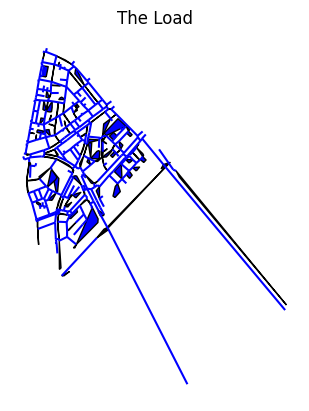

In [ ]:
ax = goo_load.convex_hull.plot(color='blue', edgecolor='black')
ax.set_title("The Load")
ax.set_axis_off()
plt.show()

In [ ]:
# 의료시설(병원)
goo_medi = gpd.sjoin(medi_gwangjin, goo_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
goo_medi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 61 entries, 294 to 20041
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   주소            61 non-null     object  
 1   병원분류          61 non-null     object  
 2   병원분류명         61 non-null     object  
 3   응급의료기관코드      61 non-null     object  
 4   응급의료기관코드명     61 non-null     object  
 5   응급실운영여부(1/2)  61 non-null     int64   
 6   기관명           61 non-null     object  
 7   위도            61 non-null     object  
 8   경도            61 non-null     object  
 9   geometry      61 non-null     geometry
 10  index_right   61 non-null     int64   
 11  ADSTRD_CD     61 non-null     int64   
 12  ADSTRD_NM     61 non-null     object  
 13  XCNTS_VALU    61 non-null     float64 
 14  YDNTS_VALU    61 non-null     float64 
 15  RELM_AR       61 non-null     float64 
dtypes: float64(3), geometry(1), int64(3), object(9)
memory usage: 8.1+ KB


In [ ]:
goo_medi = goo_medi[["주소", "geometry"]].rename(columns = {"주소": "도로명주소"})

In [ ]:
goo_medi["대분류"] = "의료시설"
goo_medi["중분류"] = "약국"

In [ ]:
goo_medi.head()

,도로명주소,geometry,대분류,중분류
294,"서울특별시 광진구 아차산로 483, 2층 (구의동)",POINT (208407.941 449057.762),의료시설,약국
649,"서울특별시 광진구 광나루로 614, 4층 (구의동, 만택빌딩)",POINT (208470.471 449036.450),의료시설,약국
653,"서울특별시 광진구 아차산로 471, 2층 (구의동, CS PLAZA)",POINT (208303.192 448990.743),의료시설,약국
654,"서울특별시 광진구 광나루로 604, 진넥스 베르디엠 403호 (구의동)",POINT (208390.817 449124.072),의료시설,약국
677,"서울특별시 광진구 광나루로 608, (구의동)",POINT (208420.701 449076.699),의료시설,약국


In [ ]:
# 의료시설(약국)
goo_pharm = gpd.sjoin(gwangjin_pharm, goo_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
goo_pharm.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 15 entries, 8 to 161
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   영업상태명        15 non-null     object  
 1   도로명주소        15 non-null     object  
 2   사업장명         15 non-null     object  
 3   위도           15 non-null     object  
 4   경도           15 non-null     object  
 5   geometry     15 non-null     geometry
 6   index_right  15 non-null     int64   
 7   ADSTRD_CD    15 non-null     int64   
 8   ADSTRD_NM    15 non-null     object  
 9   XCNTS_VALU   15 non-null     float64 
 10  YDNTS_VALU   15 non-null     float64 
 11  RELM_AR      15 non-null     float64 
dtypes: float64(3), geometry(1), int64(2), object(6)
memory usage: 1.5+ KB


In [ ]:
goo_pharm = goo_pharm[["도로명주소", "geometry"]]

In [ ]:
goo_pharm["대분류"] = "의료시설"
goo_pharm["중분류"] = "병원"

In [ ]:
goo_pharm.head()

,도로명주소,geometry,대분류,중분류
8,"서울특별시 광진구 구의강변로 106, 105호 (구의동)",POINT (208381.855 448940.089),의료시설,병원
11,"서울특별시 광진구 광나루로56길 63, 프라임프라자 107~109호 (구의동)",POINT (208498.376 448591.639),의료시설,병원
45,"서울특별시 광진구 광나루로56길 85, 테크노-마트21 지하1층 D-12호 (구의동)",POINT (208459.105 448473.596),의료시설,병원
53,"서울특별시 광진구 광나루로56길 34, 구의동현대2단지 종합상가 1층 112호 (구의동)",POINT (208542.078 448741.428),의료시설,병원
73,"서울특별시 광진구 아차산로 478, 4층 (구의동, 그레이스빌딩)",POINT (208400.133 448983.315),의료시설,병원


In [ ]:
# 생활시설
goo_market = gpd.sjoin(market_gwangjin, goo_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
goo_market.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 55 entries, 4889 to 484994
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   상권업종중분류명     55 non-null     object  
 1   도로명주소        55 non-null     object  
 2   상호명          55 non-null     object  
 3   geometry     55 non-null     geometry
 4   index_right  55 non-null     int64   
 5   ADSTRD_CD    55 non-null     int64   
 6   ADSTRD_NM    55 non-null     object  
 7   XCNTS_VALU   55 non-null     float64 
 8   YDNTS_VALU   55 non-null     float64 
 9   RELM_AR      55 non-null     float64 
dtypes: float64(3), geometry(1), int64(2), object(4)
memory usage: 4.7+ KB


In [ ]:
goo_market = goo_market[["도로명주소", "geometry"]]

In [ ]:
goo_market["대분류"] = "생활시설"
goo_market["중분류"] = "마트"

In [ ]:
goo_market.head()

,도로명주소,geometry,대분류,중분류
4889,서울특별시 광진구 강변역로4길 10,POINT (208256.899 448431.484),생활시설,마트
7338,서울특별시 광진구 구의강변로 102,POINT (208366.782 448883.170),생활시설,마트
10206,서울특별시 광진구 아차산로 473,POINT (208333.580 449005.335),생활시설,마트
13226,서울특별시 광진구 강변역로 52-2,POINT (208325.884 448412.529),생활시설,마트
17251,서울특별시 광진구 강변역로 53,POINT (208366.833 448411.683),생활시설,마트


In [ ]:
# 교통시설(버스)
gwangjin_bus = data_dict["bus"].copy()
goo_bus = gpd.sjoin(gwangjin_bus, goo_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
goo_bus.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 23 entries, 1486 to 1712
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   노드 ID        23 non-null     int64   
 1   정류소번호        23 non-null     int64   
 2   정류소명         23 non-null     object  
 3   X좌표          23 non-null     float64 
 4   Y좌표          23 non-null     float64 
 5   정류소 타입       23 non-null     object  
 6   geometry     23 non-null     geometry
 7   index_right  23 non-null     int64   
 8   ADSTRD_CD    23 non-null     int64   
 9   ADSTRD_NM    23 non-null     object  
 10  XCNTS_VALU   23 non-null     float64 
 11  YDNTS_VALU   23 non-null     float64 
 12  RELM_AR      23 non-null     float64 
dtypes: float64(5), geometry(1), int64(4), object(3)
memory usage: 2.5+ KB


In [ ]:
goo_bus = goo_bus[["정류소명", "geometry"]].rename(columns = {"정류소명": "도로명주소"})

In [ ]:
goo_bus["대분류"] = "교통시설"
goo_bus["중분류"] = "버스"

In [ ]:
goo_bus.head()

,도로명주소,geometry,대분류,중분류
1486,현대아파트앞,POINT (208308.372 448898.106),교통시설,버스
1487,현대아파트앞,POINT (208322.621 448908.165),교통시설,버스
1488,광진우체국,POINT (207990.404 448725.264),교통시설,버스
1489,강변역A,POINT (208263.767 448506.664),교통시설,버스
1490,테크노마트앞.강변역,POINT (208286.339 448600.026),교통시설,버스


In [ ]:
# 교통시설(지하철)
gwangjin_subwawy = data_dict["subway"].copy()
goo_subway = gpd.sjoin(gwangjin_subwawy, goo_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
goo_subway.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1 entries, 2 to 2
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   호선                1 non-null      object  
 1   역명                1 non-null      object  
 2   구주소               1 non-null      object  
 3   도로명주소             1 non-null      object  
 4   전화번호              1 non-null      object  
 5   filtered_address  1 non-null      object  
 6   위도                1 non-null      object  
 7   경도                1 non-null      object  
 8   geometry          1 non-null      geometry
 9   index_right       1 non-null      int64   
 10  ADSTRD_CD         1 non-null      int64   
 11  ADSTRD_NM         1 non-null      object  
 12  XCNTS_VALU        1 non-null      float64 
 13  YDNTS_VALU        1 non-null      float64 
 14  RELM_AR           1 non-null      float64 
dtypes: float64(3), geometry(1), int64(2), object(9)
memory usage: 128.0+ bytes


In [ ]:
goo_subway = goo_subway[["도로명주소", "geometry"]]

In [ ]:
goo_subway["대분류"] = "교통시설"
goo_subway["중분류"] = "지하철"

In [ ]:
goo_subway.head()

,도로명주소,geometry,대분류,중분류
2,서울특별시 광진구 강변역로 53(구의동),POINT (208366.833 448411.683),교통시설,지하철


In [ ]:
# 치안(CCTV)
gwangjin_cctv = data_dict["cctv"].copy()
goo_cctv = gpd.sjoin(gwangjin_cctv, goo_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
goo_cctv.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 277 entries, 87 to 4035
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   자치구          277 non-null    object  
 1   안심 주소        277 non-null    object  
 2   위도           277 non-null    float64 
 3   경도           277 non-null    float64 
 4   CCTV 수량      277 non-null    int64   
 5   수정 일시        277 non-null    object  
 6   geometry     277 non-null    geometry
 7   index_right  277 non-null    int64   
 8   ADSTRD_CD    277 non-null    int64   
 9   ADSTRD_NM    277 non-null    object  
 10  XCNTS_VALU   277 non-null    float64 
 11  YDNTS_VALU   277 non-null    float64 
 12  RELM_AR      277 non-null    float64 
dtypes: float64(5), geometry(1), int64(3), object(4)
memory usage: 30.3+ KB


In [ ]:
goo_cctv = goo_cctv[["안심 주소", "geometry"]].rename(columns = {"안심 주소": "도로명주소"})

In [ ]:
goo_cctv["대분류"] = "치안시설"
goo_cctv["중분류"] = "CCTV"

In [ ]:
goo_cctv.head()

,도로명주소,geometry,대분류,중분류
87,공원-구의3-002-01,POINT (208333.926 449092.083),치안시설,CCTV
88,공원-구의3-002-비상벨,POINT (208333.926 449092.083),치안시설,CCTV
89,공원-구의3-003-01,POINT (208166.359 448736.755),치안시설,CCTV
90,공원-구의3-003-비상벨,POINT (208166.359 448736.755),치안시설,CCTV
91,공원-구의3-004-01,POINT (208015.834 449025.177),치안시설,CCTV


In [ ]:
# 치안(파출소)
gwangjin_police = data_dict["police"].copy()
goo_police = gpd.sjoin(gwangjin_police, goo_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
goo_police.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 0 entries
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   연번           0 non-null      int64   
 1   시도청          0 non-null      object  
 2   경찰서          0 non-null      object  
 3   관서명          0 non-null      object  
 4   구분           0 non-null      object  
 5   전화번호         0 non-null      object  
 6   주소           0 non-null      object  
 7   위도           0 non-null      object  
 8   경도           0 non-null      object  
 9   geometry     0 non-null      geometry
 10  index_right  0 non-null      int64   
 11  ADSTRD_CD    0 non-null      int64   
 12  ADSTRD_NM    0 non-null      object  
 13  XCNTS_VALU   0 non-null      float64 
 14  YDNTS_VALU   0 non-null      float64 
 15  RELM_AR      0 non-null      float64 
dtypes: float64(3), geometry(1), int64(3), object(9)
memory usage: 0.0+ bytes


In [ ]:
goo_final = pd.concat([goo_medi, goo_pharm, goo_market, goo_bus, goo_subway, goo_cctv], axis=0)


In [ ]:
goo_final

,도로명주소,geometry,대분류,중분류
294,"서울특별시 광진구 아차산로 483, 2층 (구의동)",POINT (208407.941 449057.762),의료시설,약국
649,"서울특별시 광진구 광나루로 614, 4층 (구의동, 만택빌딩)",POINT (208470.471 449036.450),의료시설,약국
653,"서울특별시 광진구 아차산로 471, 2층 (구의동, CS PLAZA)",POINT (208303.192 448990.743),의료시설,약국
654,"서울특별시 광진구 광나루로 604, 진넥스 베르디엠 403호 (구의동)",POINT (208390.817 449124.072),의료시설,약국
677,"서울특별시 광진구 광나루로 608, (구의동)",POINT (208420.701 449076.699),의료시설,약국
...,...,...,...,...
4031,주차-구의3-013-03,POINT (208157.978 448270.598),치안시설,CCTV
4032,주차-구의3-014-01,POINT (208572.921 448726.066),치안시설,CCTV
4033,주차-구의3-014-02,POINT (208572.921 448726.066),치안시설,CCTV
4034,주차-구의3-014-03,POINT (208572.921 448726.066),치안시설,CCTV


In [ ]:
# prompt: goo_final의 geometry를 위도와 경도로 분리해줘.

goo_final["위도"] = goo_final.geometry.y
goo_final["경도"] = goo_final.geometry.x


In [ ]:
goo_final.head()

,도로명주소,geometry,대분류,중분류,위도,경도
294,"서울특별시 광진구 아차산로 483, 2층 (구의동)",POINT (208407.941 449057.762),의료시설,약국,449057.762472,208407.940568
649,"서울특별시 광진구 광나루로 614, 4층 (구의동, 만택빌딩)",POINT (208470.471 449036.450),의료시설,약국,449036.449692,208470.471491
653,"서울특별시 광진구 아차산로 471, 2층 (구의동, CS PLAZA)",POINT (208303.192 448990.743),의료시설,약국,448990.742515,208303.192165
654,"서울특별시 광진구 광나루로 604, 진넥스 베르디엠 403호 (구의동)",POINT (208390.817 449124.072),의료시설,약국,449124.071574,208390.816813
677,"서울특별시 광진구 광나루로 608, (구의동)",POINT (208420.701 449076.699),의료시설,약국,449076.698840,208420.700724


## MCLP

In [ ]:
# n clients and n facilities
client_count, facility_count = 400, 14

# candidate facilites to site
p_facilities = 3

# maximum coverage meters
max_coverage = 1000.0

# minimum coverage meters
min_coverage = 800.0

random_seeds = {"client": 3006, "facility": 1520}

title = "Neighborhood X"

In [ ]:
buff = 50
streets_buffer = get_buffer(goo_load, buff=buff)
streets_buffer

,geometry
0,"POLYGON ((208018.005 448084.458, 208015.306 44..."


In [ ]:
facilities = simulated_geo_points(
    streets_buffer, needed=facility_count, seed=random_seeds["facility"]
)

In [ ]:
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

In [ ]:
facilities

,geometry,dv
0,POINT (208380.382 448924.725),y[0]
1,POINT (209571.031 447833.390),y[1]
2,POINT (208077.140 449430.110),y[2]
3,POINT (208112.464 448559.265),y[3]
4,POINT (208537.513 448760.573),y[4]
5,POINT (207851.554 448532.752),y[5]
6,POINT (208175.475 448001.794),y[6]
7,POINT (208424.741 448718.440),y[7]
8,POINT (208942.765 447200.617),y[8]
9,POINT (208453.071 448262.819),y[9]


In [ ]:
clients = goo_final[["geometry"]]

In [ ]:
clients["weights"] = 1

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
clients["dv"] = ["x[%s]" % c for c in range((len(goo_final)))]

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
clients

,geometry,weights,dv
294,POINT (208407.941 449057.762),1,x[0]
649,POINT (208470.471 449036.450),1,x[1]
653,POINT (208303.192 448990.743),1,x[2]
654,POINT (208390.817 449124.072),1,x[3]
677,POINT (208420.701 449076.699),1,x[4]
...,...,...,...
4031,POINT (208157.978 448270.598),1,x[427]
4032,POINT (208572.921 448726.066),1,x[428]
4033,POINT (208572.921 448726.066),1,x[429]
4034,POINT (208572.921 448726.066),1,x[430]


In [ ]:

ntw = spaghetti.Network(in_data=goo_load)

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:947: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  w = weights.W(neighbors, **weights_kws)
/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:947: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: (224, 424).
  w = weights.W(neighbors, **weights_kws)


In [ ]:
ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:3414: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/usr/local/lib/python3.10/dist-packages/spaghetti/util.py:583: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
/usr/local/lib/python3.10/dist-packages/libpysal/cg/shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(
/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:3414: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/usr/local/lib/python3.10/dist-packages/spaghetti/util.p

In [ ]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3, :3]

array([[246.64570738,          inf, 527.67028793],
       [184.00179872,          inf, 577.35887412],
       [305.42210596,          inf, 628.8441387 ]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=p_facilities, s=min_coverage
)
clients, facilities = add_results(mclp, clients, facilities)

Solve Time: 0.0050666768 minutes
Obj. Value: 432.0 residents within 800.000000 meters of 3 selected facilities
Percent of 432 clients covered: 100.000000
--- 0 clients are not covered
--- 432 clients are covered by 1 facility
--- 365 clients are covered by 2 facilities
--- 59 clients are covered by 3 facilities


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-6-fc4204e9bd1d>:483: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name].fillna("closed", inplace=True)


In [ ]:
aux_to_plot = {"streets": goo_load, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=300,
    pt2_size=60,
    model=mclp,
    title=title,
)

/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


In [ ]:
models = [mclp]
analytics_df, analytics_display = analytics_matrix(models)
selection_df, selection_display = selection_matrix(models)
display(analytics_display)
display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

,stats,mclp
0,abs_min,16.755452
1,abs_max,799.180772
2,mean_means,483.642971
3,mean_stds,201.980920


,mclp,$\sum$,$\%$
y[0],$\notin$,0.000000,0.000000
y[1],$\notin$,0.000000,0.000000
y[2],$\in$,1.000000,25.000000
y[3],$\notin$,0.000000,0.000000
y[4],$\notin$,0.000000,0.000000
y[5],$\notin$,0.000000,0.000000
y[6],$\notin$,0.000000,0.000000
y[7],$\in$,1.000000,25.000000
y[8],$\notin$,0.000000,0.000000
y[9],$\notin$,0.000000,0.000000


,dv,geometry
2,y[2],POINT (208077.140 449430.110)
7,y[7],POINT (208424.741 448718.440)
12,y[12],POINT (208051.785 448354.494)


In [ ]:
candi_df = facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]]
candi_df["geometry"] = candi_df.geometry.to_crs("EPSG:4326")

In [ ]:
candi_df

,dv,geometry
2,y[2],POINT (127.09140 37.54435)
7,y[7],POINT (127.09532 37.53793)
12,y[12],POINT (127.09110 37.53466)


# 화양동

## Data Pre-processing

In [18]:
gwangjin_admin = data_dict["gwangjin_admin"].copy()

In [19]:
gwangjin_admin.head()

,ADSTRD_CD,ADSTRD_NM,XCNTS_VALU,YDNTS_VALU,RELM_AR,geometry
58,11215840,자양3동,206277.0,447988.0,1196419.0,"POLYGON ((206502.191 448833.470, 206557.876 44..."
59,11215847,자양4동,205623.0,448252.0,1180023.0,"POLYGON ((206164.104 448956.578, 206210.110 44..."
60,11215850,구의1동,207599.0,449114.0,565313.0,"POLYGON ((207972.337 449261.113, 207965.893 44..."
61,11215860,구의2동,208382.0,450180.0,1388041.0,"POLYGON ((209270.675 450767.066, 209269.698 45..."
62,11215870,구의3동,208328.0,448610.0,1027561.0,"POLYGON ((208172.878 449404.420, 208188.854 44..."


In [20]:
hwa_admin = gwangjin_admin[gwangjin_admin["ADSTRD_NM"] == "화양동"]

In [21]:
hwa_load = gpd.sjoin(load_gdf, hwa_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


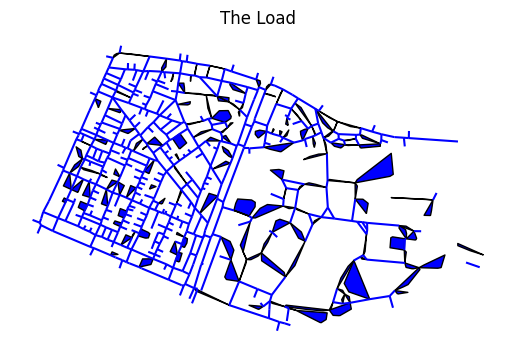

In [22]:
ax = hwa_load.convex_hull.plot(color='blue', edgecolor='black')
ax.set_title("The Load")
ax.set_axis_off()
plt.show()

In [23]:
# 의료시설(병원)
hwa_medi = gpd.sjoin(medi_gwangjin, hwa_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [24]:
hwa_medi.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 66 entries, 11 to 20091
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   주소            66 non-null     object  
 1   병원분류          66 non-null     object  
 2   병원분류명         66 non-null     object  
 3   응급의료기관코드      66 non-null     object  
 4   응급의료기관코드명     66 non-null     object  
 5   응급실운영여부(1/2)  66 non-null     int64   
 6   기관명           66 non-null     object  
 7   위도            66 non-null     object  
 8   경도            66 non-null     object  
 9   geometry      66 non-null     geometry
 10  index_right   66 non-null     int64   
 11  ADSTRD_CD     66 non-null     int64   
 12  ADSTRD_NM     66 non-null     object  
 13  XCNTS_VALU    66 non-null     float64 
 14  YDNTS_VALU    66 non-null     float64 
 15  RELM_AR       66 non-null     float64 
dtypes: float64(3), geometry(1), int64(3), object(9)
memory usage: 8.8+ KB


In [25]:
hwa_medi = hwa_medi[["주소", "geometry"]].rename(columns = {"주소": "도로명주소"})

In [26]:
hwa_medi["대분류"] = "의료시설"
hwa_medi["중분류"] = "약국"

In [27]:
hwa_medi.head()

,도로명주소,geometry,대분류,중분류
11,"서울특별시 광진구 능동로 103, 5층 1호 (화양동)",POINT (206231.797 448983.648),의료시설,약국
487,"서울특별시 광진구 능동로13길 11, 2,3층 (화양동)",POINT (206280.219 449240.577),의료시설,약국
627,"서울특별시 광진구 능동로 103, 202호 (화양동)",POINT (206231.797 448983.648),의료시설,약국
801,"서울특별시 광진구 능동로13길 39, 3층 (화양동)",POINT (206165.843 449385.331),의료시설,약국
1034,"서울특별시 광진구 아차산로 229, 4층 (화양동, 한림타워)",POINT (206105.244 449038.038),의료시설,약국


In [28]:
# 의료시설(약국)
hwa_pharm = gpd.sjoin(gwangjin_pharm, hwa_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [29]:
hwa_pharm.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 13 entries, 1 to 153
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   영업상태명        13 non-null     object  
 1   도로명주소        13 non-null     object  
 2   사업장명         13 non-null     object  
 3   위도           13 non-null     object  
 4   경도           13 non-null     object  
 5   geometry     13 non-null     geometry
 6   index_right  13 non-null     int64   
 7   ADSTRD_CD    13 non-null     int64   
 8   ADSTRD_NM    13 non-null     object  
 9   XCNTS_VALU   13 non-null     float64 
 10  YDNTS_VALU   13 non-null     float64 
 11  RELM_AR      13 non-null     float64 
dtypes: float64(3), geometry(1), int64(2), object(6)
memory usage: 1.3+ KB


In [30]:
hwa_pharm = hwa_pharm[["도로명주소", "geometry"]]

In [31]:
hwa_pharm["대분류"] = "의료시설"
hwa_pharm["중분류"] = "병원"

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [32]:
hwa_pharm.head()

,도로명주소,geometry,대분류,중분류
1,"서울특별시 광진구 아차산로 219, 삼영빌딩 1층 (화양동)",POINT (206004.452 449070.606),의료시설,병원
30,"서울특별시 광진구 능동로 110, 스타시티영존빌딩 1층 (화양동)",POINT (206311.221 449019.379),의료시설,병원
47,"서울특별시 광진구 능동로 110, 스타시티영존 지하2층 B203-1,204호 (화양동)",POINT (206311.221 449019.379),의료시설,병원
52,"서울특별시 광진구 동일로 178, 광진캠퍼스시티 1층 104호 (화양동)",POINT (205987.301 449815.112),의료시설,병원
59,"서울특별시 광진구 아차산로 229, 한림타워 1층 103호 (화양동)",POINT (206105.244 449038.038),의료시설,병원


In [33]:
# 생활시설
hwa_market = gpd.sjoin(market_gwangjin, hwa_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [34]:
hwa_market.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 90 entries, 7308 to 489351
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   상권업종중분류명     90 non-null     object  
 1   도로명주소        90 non-null     object  
 2   상호명          90 non-null     object  
 3   geometry     90 non-null     geometry
 4   index_right  90 non-null     int64   
 5   ADSTRD_CD    90 non-null     int64   
 6   ADSTRD_NM    90 non-null     object  
 7   XCNTS_VALU   90 non-null     float64 
 8   YDNTS_VALU   90 non-null     float64 
 9   RELM_AR      90 non-null     float64 
dtypes: float64(3), geometry(1), int64(2), object(4)
memory usage: 7.7+ KB


In [35]:
hwa_market = hwa_market[["도로명주소", "geometry"]]

In [36]:
hwa_market["대분류"] = "생활시설"
hwa_market["중분류"] = "마트"

In [37]:
hwa_market.head()

,도로명주소,geometry,대분류,중분류
7308,서울특별시 광진구 아차산로 219,POINT (206004.452 449070.606),생활시설,마트
16580,서울특별시 광진구 동일로24길 27,POINT (205890.152 449361.168),생활시설,마트
41393,서울특별시 광진구 동일로24길 30,POINT (205901.921 449339.290),생활시설,마트
41995,서울특별시 광진구 능동로 120,POINT (206712.387 449377.885),생활시설,마트
42007,서울특별시 광진구 능동로19길 9,POINT (206468.831 449715.606),생활시설,마트


In [38]:
# 교통시설(버스)
gwangjin_bus = data_dict["bus"].copy()
hwa_bus = gpd.sjoin(gwangjin_bus, hwa_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [39]:
hwa_bus.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 21 entries, 1539 to 1707
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   노드 ID        21 non-null     int64   
 1   정류소번호        21 non-null     int64   
 2   정류소명         21 non-null     object  
 3   X좌표          21 non-null     float64 
 4   Y좌표          21 non-null     float64 
 5   정류소 타입       21 non-null     object  
 6   geometry     21 non-null     geometry
 7   index_right  21 non-null     int64   
 8   ADSTRD_CD    21 non-null     int64   
 9   ADSTRD_NM    21 non-null     object  
 10  XCNTS_VALU   21 non-null     float64 
 11  YDNTS_VALU   21 non-null     float64 
 12  RELM_AR      21 non-null     float64 
dtypes: float64(5), geometry(1), int64(4), object(3)
memory usage: 2.3+ KB


In [40]:
hwa_bus = hwa_bus[["정류소명", "geometry"]].rename(columns = {"정류소명": "도로명주소"})

In [41]:
hwa_bus["대분류"] = "교통시설"
hwa_bus["중분류"] = "버스"

In [42]:
hwa_bus.head()

,도로명주소,geometry,대분류,중분류
1539,성수사거리,POINT (205724.601 449296.148),교통시설,버스
1540,화양사거리,POINT (205928.598 449748.382),교통시설,버스
1541,광진광장,POINT (206320.243 449802.314),교통시설,버스
1542,어린이대공원역.화양천주교회,POINT (206506.583 449681.089),교통시설,버스
1543,한아름공원,POINT (206382.534 449363.940),교통시설,버스


In [43]:
# 교통시설(지하철)
gwangjin_subwawy = data_dict["subway"].copy()
hwa_subway = gpd.sjoin(gwangjin_subwawy, hwa_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [44]:
hwa_subway.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2 entries, 0 to 9
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   호선                2 non-null      object  
 1   역명                2 non-null      object  
 2   구주소               2 non-null      object  
 3   도로명주소             2 non-null      object  
 4   전화번호              2 non-null      object  
 5   filtered_address  2 non-null      object  
 6   위도                2 non-null      object  
 7   경도                2 non-null      object  
 8   geometry          2 non-null      geometry
 9   index_right       2 non-null      int64   
 10  ADSTRD_CD         2 non-null      int64   
 11  ADSTRD_NM         2 non-null      object  
 12  XCNTS_VALU        2 non-null      float64 
 13  YDNTS_VALU        2 non-null      float64 
 14  RELM_AR           2 non-null      float64 
dtypes: float64(3), geometry(1), int64(2), object(9)
memory usage: 256.0+ bytes


In [45]:
hwa_subway = hwa_subway[["도로명주소", "geometry"]]

In [46]:
hwa_subway["대분류"] = "교통시설"
hwa_subway["중분류"] = "지하철"

In [47]:
hwa_subway.head()

,도로명주소,geometry,대분류,중분류
0,서울특별시 광진구 아차산로 243(화양동),POINT (206113.382 448992.361),교통시설,지하철
9,서울특별시 광진구 능동로 지하110(화양동),POINT (206311.221 449019.379),교통시설,지하철


In [48]:
# 치안(CCTV)
gwangjin_cctv = data_dict["cctv"].copy()
hwa_cctv = gpd.sjoin(gwangjin_cctv, hwa_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [49]:
hwa_cctv.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 306 entries, 266 to 4089
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   자치구          306 non-null    object  
 1   안심 주소        306 non-null    object  
 2   위도           306 non-null    float64 
 3   경도           306 non-null    float64 
 4   CCTV 수량      306 non-null    int64   
 5   수정 일시        306 non-null    object  
 6   geometry     306 non-null    geometry
 7   index_right  306 non-null    int64   
 8   ADSTRD_CD    306 non-null    int64   
 9   ADSTRD_NM    306 non-null    object  
 10  XCNTS_VALU   306 non-null    float64 
 11  YDNTS_VALU   306 non-null    float64 
 12  RELM_AR      306 non-null    float64 
dtypes: float64(5), geometry(1), int64(3), object(4)
memory usage: 33.5+ KB


In [50]:
hwa_cctv = hwa_cctv[["안심 주소", "geometry"]].rename(columns = {"안심 주소": "도로명주소"})

In [51]:
hwa_cctv["대분류"] = "치안시설"
hwa_cctv["중분류"] = "CCTV"

In [52]:
hwa_cctv.head()

,도로명주소,geometry,대분류,중분류
266,공원-화양-027-01,POINT (205982.681 449678.294),치안시설,CCTV
267,공원-화양-027-비상벨,POINT (205982.681 449678.294),치안시설,CCTV
268,공원-화양-028-01,POINT (205903.431 449278.680),치안시설,CCTV
269,공원-화양-028-비상벨,POINT (205903.431 449278.680),치안시설,CCTV
270,공원-화양-029-01,POINT (206345.000 449678.563),치안시설,CCTV


In [53]:
# 치안(파출소)
gwangjin_police = data_dict["police"].copy()
hwa_police = gpd.sjoin(gwangjin_police, hwa_admin, how="inner", op='intersects')

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [54]:
hwa_police.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1 entries, 1 to 1
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   연번           1 non-null      int64   
 1   시도청          1 non-null      object  
 2   경찰서          1 non-null      object  
 3   관서명          1 non-null      object  
 4   구분           1 non-null      object  
 5   전화번호         1 non-null      object  
 6   주소           1 non-null      object  
 7   위도           1 non-null      object  
 8   경도           1 non-null      object  
 9   geometry     1 non-null      geometry
 10  index_right  1 non-null      int64   
 11  ADSTRD_CD    1 non-null      int64   
 12  ADSTRD_NM    1 non-null      object  
 13  XCNTS_VALU   1 non-null      float64 
 14  YDNTS_VALU   1 non-null      float64 
 15  RELM_AR      1 non-null      float64 
dtypes: float64(3), geometry(1), int64(3), object(9)
memory usage: 136.0+ bytes


In [55]:
hwa_police = hwa_police[["주소", "geometry"]].rename(columns = {"주소": "도로명주소"})

In [56]:
hwa_police["대분류"] = "치안시설"
hwa_police["중분류"] = "파출소"

In [57]:
hwa_police.head()

,도로명주소,geometry,대분류,중분류
1,서울특별시 광진구 능동로17길 39,POINT (206302.163 449672.104),치안시설,파출소


In [58]:
hwa_final = pd.concat([hwa_medi, hwa_pharm, hwa_market, hwa_bus, hwa_subway, hwa_cctv, hwa_police], axis=0)

In [ ]:
# hwa_final = hwa_final.to_crs("EPSG:5181") # "EPSG:5181"

In [ ]:
hwa_final["위도"] = hwa_final.geometry.y
hwa_final["경도"] = hwa_final.geometry.x

In [73]:
hwa_final.sample(8).to_excel("MCLP_data_sample.xlsx")

In [63]:
hwa_final = hwa_final.drop_duplicates(subset="도로명주소", keep="last")

In [ ]:
hwa_final = hwa_final[hwa_final.loc[:, "geometry"].x != hwa_final.loc[:, "geometry"].x.max()]

In [ ]:
hwa_final = hwa_final[hwa_final["도로명주소"] != "서울특별시 광진구 능동로 120"]

In [ ]:
hwa_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 460 entries, 11 to 1
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   도로명주소     460 non-null    object  
 1   geometry  460 non-null    geometry
 2   대분류       460 non-null    object  
 3   중분류       460 non-null    object  
 4   위도        460 non-null    float64 
 5   경도        460 non-null    float64 
dtypes: float64(2), geometry(1), object(3)
memory usage: 25.2+ KB


In [ ]:
hwa_final_buffer = gpd.GeoDataFrame(hwa_final.buffer(50))
hwa_final_buffer.rename(columns = {hwa_final_buffer.columns[0]: "geometry"}, inplace = True)
hwa_final_buffer.reset_index(inplace = True, drop = True)
hwa_final_buffer.set_geometry("geometry", inplace=True)
hwa_final_buffer.to_crs("EPSG:5181", inplace=True)

In [ ]:
hwa_final_buffer.head()

,geometry
0,"POLYGON ((206281.797 448983.648, 206281.556 44..."
1,"POLYGON ((206330.219 449240.577, 206329.979 44..."
2,"POLYGON ((206155.244 449038.038, 206155.003 44..."
3,"POLYGON ((206266.059 449819.220, 206265.818 44..."
4,"POLYGON ((206231.444 449820.104, 206231.203 44..."


In [ ]:
hwa_load.rename(columns = {"index_right": "IDK"}, inplace = True)

In [ ]:
hwa_load_filtered = gpd.sjoin(hwa_load, hwa_final_buffer, how="inner", op='intersects')


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
hwa_load_filtered.head()

,ID,Length,geometry,IDK,ADSTRD_CD,ADSTRD_NM,XCNTS_VALU,YDNTS_VALU,RELM_AR,index_right
67862,182060,27.054,"LINESTRING (206447.542 449612.411, 206443.097 ...",111,11215710,화양동,206486.0,449309.0,1166008.0,100
68410,191432,53.312,"LINESTRING (206448.812 449637.176, 206424.092 ...",111,11215710,화양동,206486.0,449309.0,1166008.0,100
68583,77255,81.332,"LINESTRING (206467.862 449582.566, 206441.192 ...",111,11215710,화양동,206486.0,449309.0,1166008.0,100
70604,274414,102.647,"LINESTRING (206543.261 449700.666, 206506.597 ...",111,11215710,화양동,206486.0,449309.0,1166008.0,100
71257,34504,31.221,"LINESTRING (206462.757 449663.444, 206458.718 ...",111,11215710,화양동,206486.0,449309.0,1166008.0,100


In [ ]:
hwa_load = hwa_load_filtered

In [ ]:
hwa_load = hwa_load.drop(columns=["index_right"])


In [ ]:
hwa_load.rename(columns = {"IDK": "index_right"}, inplace = True)

In [ ]:
hwa_load.head()

,ID,Length,geometry,index_right,ADSTRD_CD,ADSTRD_NM,XCNTS_VALU,YDNTS_VALU,RELM_AR
67862,182060,27.054,"LINESTRING (206447.542 449612.411, 206443.097 ...",111,11215710,화양동,206486.0,449309.0,1166008.0
68410,191432,53.312,"LINESTRING (206448.812 449637.176, 206424.092 ...",111,11215710,화양동,206486.0,449309.0,1166008.0
68583,77255,81.332,"LINESTRING (206467.862 449582.566, 206441.192 ...",111,11215710,화양동,206486.0,449309.0,1166008.0
70604,274414,102.647,"LINESTRING (206543.261 449700.666, 206506.597 ...",111,11215710,화양동,206486.0,449309.0,1166008.0
71257,34504,31.221,"LINESTRING (206462.757 449663.444, 206458.718 ...",111,11215710,화양동,206486.0,449309.0,1166008.0


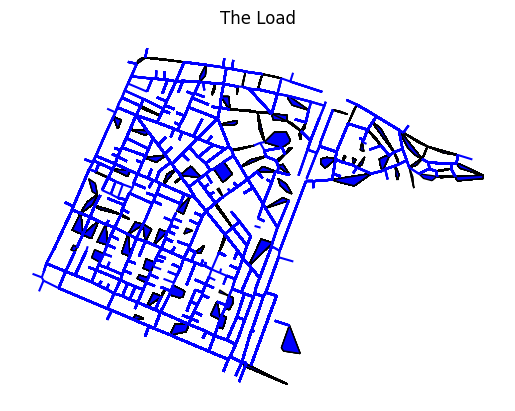

In [ ]:
ax = hwa_load.convex_hull.plot(color='blue', edgecolor='black')
ax.set_title("The Load")
ax.set_axis_off()
plt.show()

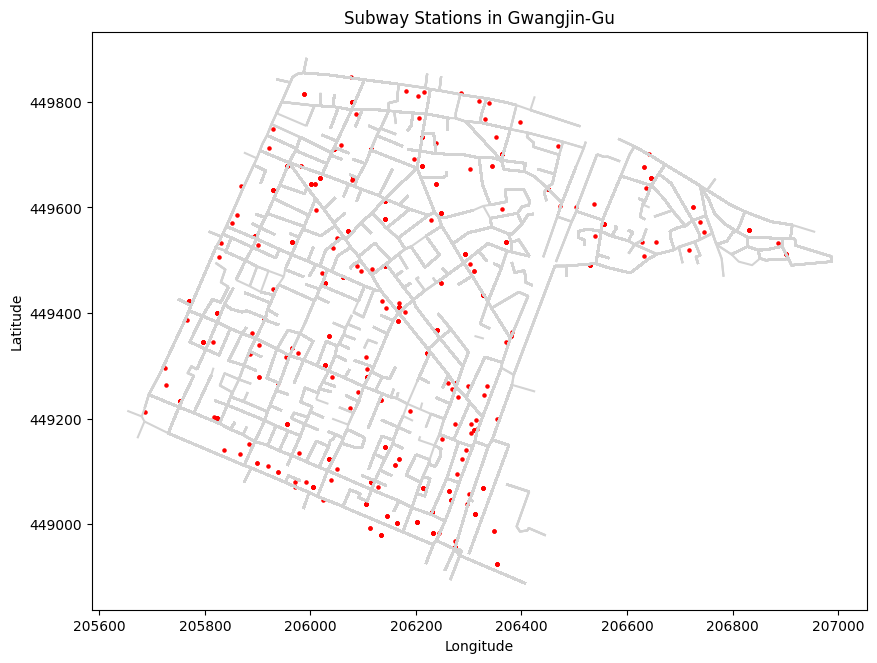

In [ ]:
# Plot the gwanjin map
hwa_load.plot(figsize=(10, 10), color='lightgray', edgecolor='black')

# Plot the subway_gdf points
hwa_final.plot(ax=plt.gca(), color='red', markersize=5)

# Set the title and labels
plt.title('Subway Stations in Gwangjin-Gu')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

## MCLP

In [ ]:
# n clients and n facilities
client_count, facility_count = 400, 14

# candidate facilites to site
p_facilities = 3

# maximum coverage meters
max_coverage = 3000.0

# minimum coverage meters
min_coverage = 2000.0

random_seeds = {"client": 3000, "facility": 1300}

title = "Neighborhood X"

In [ ]:
buff = 200
streets_buffer = get_buffer(hwa_load, buff=buff)
streets_buffer

,geometry
0,"POLYGON ((205594.761 448978.275, 205577.060 44..."


In [ ]:
facilities = simulated_geo_points(
    streets_buffer, needed=facility_count, seed=random_seeds["facility"]
)

In [ ]:
facilities["dv"] = ["y[%s]" % c for c in range(facility_count)]

In [ ]:
facilities

,geometry,dv
0,POINT (206008.938 449869.178),y[0]
1,POINT (205765.500 449354.476),y[1]
2,POINT (206337.028 449405.543),y[2]
3,POINT (205976.077 449556.507),y[3]
4,POINT (206067.322 449482.227),y[4]
5,POINT (206249.805 449096.723),y[5]
6,POINT (206422.923 449109.754),y[6]
7,POINT (207095.904 449440.146),y[7]
8,POINT (205941.208 449822.989),y[8]
9,POINT (207090.210 449440.490),y[9]


In [ ]:

clients = hwa_final[["geometry"]]

In [ ]:
clients["weights"] = 1

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
clients["dv"] = ["x[%s]" % c for c in range(460)]

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
clients

,geometry,weights,dv
11,POINT (206231.797 448983.648),1,x[0]
487,POINT (206280.219 449240.577),1,x[1]
1034,POINT (206105.244 449038.038),1,x[2]
1227,POINT (206216.059 449819.220),1,x[3]
1274,POINT (206181.444 449820.104),1,x[4]
...,...,...,...
4086,POINT (206310.031 449179.090),1,x[455]
4087,POINT (206265.943 449045.871),1,x[456]
4088,POINT (206265.943 449045.871),1,x[457]
4089,POINT (206265.943 449045.871),1,x[458]


In [ ]:
ntw = spaghetti.Network(in_data=hwa_load)

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:947: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There is 1 island with id: (527, 528).
  w = weights.W(neighbors, **weights_kws)
/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:947: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There are 4 islands with ids: (176, 178), (246, 251), (519, 647), (527, 528).
  w = weights.W(neighbors, **weights_kws)


In [ ]:

ntw.snapobservations(clients, "clients", attribute=True)
clients_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="clients", snapped=True
)
ntw.snapobservations(facilities, "facilities", attribute=True)
facilities_snapped = spaghetti.element_as_gdf(
    ntw, pp_name="facilities", snapped=True
)

/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:3414: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/usr/local/lib/python3.10/dist-packages/spaghetti/util.py:583: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
/usr/local/lib/python3.10/dist-packages/libpysal/cg/shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(
/usr/local/lib/python3.10/dist-packages/spaghetti/network.py:3414: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/usr/local/lib/python3.10/dist-packages/spaghetti/util.p

In [ ]:
cost_matrix = ntw.allneighbordistances(
    sourcepattern=ntw.pointpatterns["clients"],
    destpattern=ntw.pointpatterns["facilities"],
)
cost_matrix[:3, :3]

array([[1099.81397132,  764.23989176,  494.92328272],
       [ 801.59010061,  594.68302441,  310.55690733],
       [1008.33038316,  606.37184547,  632.30534656]])

In [ ]:
mclp = FacilityLocationModel(
    "mclp", ai=clients["weights"], cij=cost_matrix, p=p_facilities, s=min_coverage
)
clients, facilities = add_results(mclp, clients, facilities)

Solve Time: 0.0030000060000000004 minutes
Obj. Value: 460.0 residents within 2000.000000 meters of 3 selected facilities
Percent of 460 clients covered: 100.000000
--- 0 clients are not covered
--- 460 clients are covered by 1 facility
--- 460 clients are covered by 2 facilities


/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-633-fc4204e9bd1d>:483: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col_name].fillna("closed", inplace=True)


/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 2

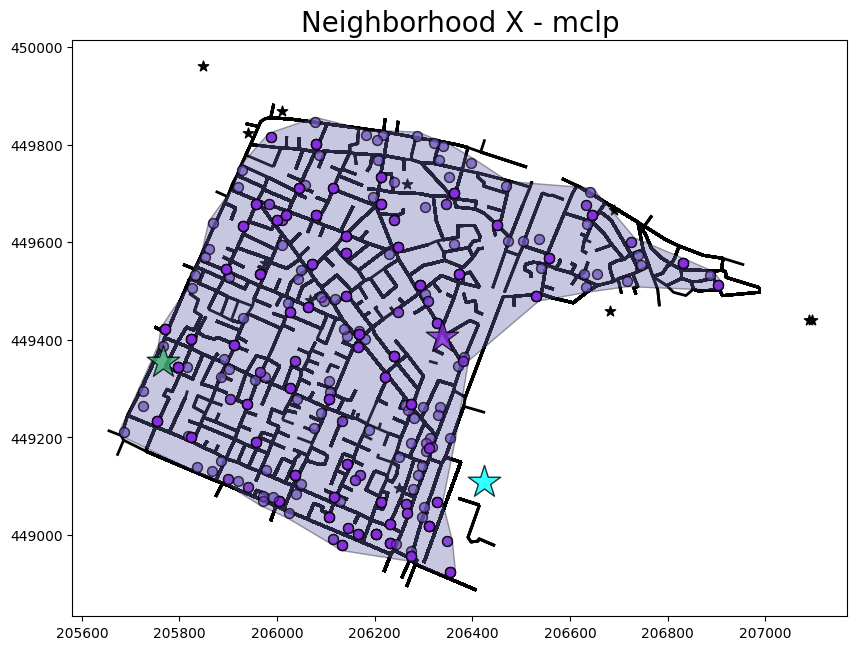

In [ ]:
aux_to_plot = {"streets": hwa_load, "cli_tru": clients, "fac_tru": facilities}
res_to_plot = {"cli_var": clients, "fac_var": facilities}
plotter(
    plot_aux=aux_to_plot,
    plot_res=res_to_plot,
    pt1_size=200,
    pt2_size=60,
    model=mclp,
    title=title
)

In [ ]:
models = [mclp]
# analytics_df, analytics_display = analytics_matrix(models)
# selection_df, selection_display = selection_matrix(models)
# display(analytics_display)
# display(selection_display)
display(facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]])

,dv,geometry
1,y[1],POINT (205765.500 449354.476)
2,y[2],POINT (206337.028 449405.543)
6,y[6],POINT (206422.923 449109.754)


In [ ]:
candi_df = facilities[facilities["mclp_sol"] != "closed"][["dv", "geometry"]]
candi_df["geometry"] = candi_df.geometry.to_crs("EPSG:4326")

In [ ]:
candi_df

,dv,geometry
1,y[1],POINT (127.06633 37.54374)
2,y[2],POINT (127.07168 37.54410)
3,y[3],POINT (127.06830 37.54517)
